In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
from matplotlib import pyplot
# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

import yfinance as yf
import yahoo_fin.stock_info as si
# import pandas_datareader.data as web

from dateutil.relativedelta import relativedelta
from datetime import datetime

pd.set_option('display.max_rows', None, 'display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# treat inf as Nan
pd.set_option('use_inf_as_na', True)

## Model 1 
#### Target T0_5>0 --> Event 
#### Target T0_5<0 --> Non-event

In [2]:
dfmdl1=pd.read_csv('data/model_1.csv')

In [3]:
dfmdl1.shape

(8259, 84)

In [4]:
dfmdl1.isna().sum()

Ticker                     0
beta_30avg                13
adjclose                  13
Fiscal Year                0
Fiscal Period              0
Revenue                    4
Net_income                 0
Shares                     0
Cash                       7
Assets                     0
CFO                        0
CAPX                    4450
Dividends               1844
FCF                        0
EPSsuprise_ind             0
Revenue_qoq              417
Revenue_yoy             1731
Net_Income_qoq           418
Net_Income_yoy          1732
Gross_margin             403
Gross_margin_qoq         810
Gross_margin_yoy        2075
Operating_margin           4
Operating_margin_qoq     423
Operating_margin_yoy    1739
Net_margin                 4
Net_margin_qoq           423
Net_margin_yoy          1739
Cash_yoy                1733
Assets_yoy              1731
Leverage                   0
CFO_qoq                  418
FCF_qoq                  431
Sector                     0
Industry      

### Step 1. Logic to fill missing values

In [5]:
# Drop rows where the target is missing
dfmdl1=dfmdl1.dropna(subset=['T0_5'])
dfmdl1.shape

(7841, 84)

In [6]:
# Assume following attributes as 0 when missing
dfmdl1['CAPX'] = dfmdl1['CAPX'].fillna(0)
dfmdl1['Dividends'] = dfmdl1['Dividends'].fillna(0)
dfmdl1['Dividend_yields_new'] = dfmdl1['Dividend_yields_new'].fillna(0)
dfmdl1['Assets_yoy'] = dfmdl1['Assets_yoy'].fillna(0)
dfmdl1['Cash_yoy'] = dfmdl1['Cash_yoy'].fillna(0)
dfmdl1['CFO_qoq'] = dfmdl1['CFO_qoq'].fillna(0)
dfmdl1['FCF_qoq'] = dfmdl1['FCF_qoq'].fillna(0)

# Assume missing gross margin = net margin  (rationale: certain industry doesn't report gross margin)
dfmdl1['Gross_margin'] = dfmdl1['Gross_margin'].fillna(dfmdl1['Operating_margin'])

# Assume missing QoQ change from average
dfmdl1["Revenue_qoq"]  = dfmdl1['Revenue_qoq'].fillna(dfmdl1.groupby('Ticker')['Revenue_qoq'].transform('mean'))
dfmdl1["Net_Income_qoq"]  = dfmdl1['Net_Income_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_Income_qoq'].transform('mean'))
dfmdl1["Gross_margin_qoq"]  = dfmdl1['Gross_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Gross_margin_qoq'].transform('mean'))
dfmdl1["Operating_margin_qoq"]  = dfmdl1['Operating_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Operating_margin_qoq'].transform('mean'))
dfmdl1["Net_margin_qoq"]  = dfmdl1['Net_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_margin_qoq'].transform('mean'))
# if still missing: 
dfmdl1["Gross_margin_qoq"]  = dfmdl1['Gross_margin_qoq'].fillna(dfmdl1['Operating_margin_qoq'])


# Assume missing YoY change is interpolated from QoQ 
def interpolation(df,var):
    df[var+'_yoy'].fillna((1+df[var+'_qoq'])**4-1, inplace=True)
    return df

for var in ['Revenue','Net_Income','Gross_margin','Operating_margin','Net_margin']:
    interpolation(dfmdl1,var)

# Assume missing sentiment score from ticker's average, it still missing then 0
dfmdl1["cs_last5"]  = dfmdl1['cs_last5'].fillna(dfmdl1.groupby('Ticker')['cs_last5'].transform('mean'))
dfmdl1['cs_last5'] = dfmdl1['cs_last5'].fillna(0)

In [7]:
dfmdl1.isna().sum()

Ticker                   0
beta_30avg              12
adjclose                12
Fiscal Year              0
Fiscal Period            0
Revenue                  4
Net_income               0
Shares                   0
Cash                     5
Assets                   0
CFO                      0
CAPX                     0
Dividends                0
FCF                      0
EPSsuprise_ind           0
Revenue_qoq              3
Revenue_yoy              3
Net_Income_qoq           5
Net_Income_yoy           4
Gross_margin             4
Gross_margin_qoq         3
Gross_margin_yoy         3
Operating_margin         4
Operating_margin_qoq     3
Operating_margin_yoy     3
Net_margin               4
Net_margin_qoq           3
Net_margin_yoy           3
Cash_yoy                 0
Assets_yoy               0
Leverage                 0
CFO_qoq                  0
FCF_qoq                  0
Sector                   0
Industry                 0
Next_EarningDate         0
RSI                      0
M

In [8]:
# drop rows still with NA (should be less than 12)
dfmdl1.dropna(inplace=True)
dfmdl1.shape

(7811, 84)

In [9]:
dfmdl1.isna().sum().sum()

0

### Step 2. Define Target

In [10]:
dfmdl1['target'] = np.where(dfmdl1['T0_5']>0, 1, 0)

### Step 3. Data Exploration

In [11]:
dfmdl1.columns

Index(['Ticker', 'beta_30avg', 'adjclose', 'Fiscal Year', 'Fiscal Period',
       'Revenue', 'Net_income', 'Shares', 'Cash', 'Assets', 'CFO', 'CAPX',
       'Dividends', 'FCF', 'EPSsuprise_ind', 'Revenue_qoq', 'Revenue_yoy',
       'Net_Income_qoq', 'Net_Income_yoy', 'Gross_margin', 'Gross_margin_qoq',
       'Gross_margin_yoy', 'Operating_margin', 'Operating_margin_qoq',
       'Operating_margin_yoy', 'Net_margin', 'Net_margin_qoq',
       'Net_margin_yoy', 'Cash_yoy', 'Assets_yoy', 'Leverage', 'CFO_qoq',
       'FCF_qoq', 'Sector', 'Industry', 'Next_EarningDate', 'RSI', 'MFI',
       'adjclose_SMA_12', 'adjclose_SMA_30', 'adjclose_EWMA_12',
       'adjclose_EWMA_30', 'adjclose_UpperBand', 'adjclose_LowerBand',
       'SMA_12_SMA_30', 'EWMA_12_EWMA_30', 'UpperBand_LowerBand', '^GSPC',
       '^GSPC_pctchange_5', '^GSPC_pctchange_21', '^GSPC_pctchange_yoy',
       '^RUT', '^RUT_pctchange_5', '^RUT_pctchange_21', '^RUT_pctchange_yoy',
       '^VIX', '^VIX_pctchange_5', '^VIX_pctchange_2

In [12]:
dfmdl1.describe()

,beta_30avg,adjclose,Fiscal Year,Revenue,Net_income,Shares,Cash,Assets,CFO,CAPX,Dividends,FCF,Revenue_qoq,Revenue_yoy,Net_Income_qoq,Net_Income_yoy,Gross_margin,Gross_margin_qoq,Gross_margin_yoy,Operating_margin,Operating_margin_qoq,Operating_margin_yoy,Net_margin,Net_margin_qoq,Net_margin_yoy,Cash_yoy,Assets_yoy,Leverage,CFO_qoq,FCF_qoq,RSI,MFI,adjclose_SMA_12,adjclose_SMA_30,adjclose_EWMA_12,adjclose_EWMA_30,adjclose_UpperBand,adjclose_LowerBand,SMA_12_SMA_30,EWMA_12_EWMA_30,UpperBand_LowerBand,^GSPC,^GSPC_pctchange_5,^GSPC_pctchange_21,^GSPC_pctchange_yoy,^RUT,^RUT_pctchange_5,^RUT_pctchange_21,^RUT_pctchange_yoy,^VIX,^VIX_pctchange_5,^VIX_pctchange_21,^VIX_pctchange_yoy,GC=F,GC=F_pctchange_5,GC=F_pctchange_21,GC=F_pctchange_yoy,CL=F,CL=F_pctchange_5,CL=F_pctchange_21,CL=F_pctchange_yoy,^TNX,^TNX_pctchange_5,^TNX_pctchange_21,^TNX_pctchange_yoy,^FVX,^FVX_pctchange_5,^FVX_pctchange_21,^FVX_pctchange_yoy,cs_last5,T0,sameday_jump,T0_5,PE_new,PS_new,PB_new,Dividend_yields_new,Market_cap_mm,target
count,7811.000000,7811.000000,7811.000000,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7811.000000,7.811000e+03,7811.000000,7.811000e+03,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7.811000e+03,7811.000000
mean,0.987890,110.048690,2018.181027,5.637686e+09,4.857689e+08,6.498256e+08,3.914169e+09,3.516209e+10,8.981464e+08,1.517504e+07,-2.459358e+08,7.374899e+07,0.029186,4.192672e+02,0.192820,1.316949e+07,0.443644,-0.003548,7.787397,0.121191,-0.019172,0.050178,0.053727,-0.023214,0.343886,0.548916,0.095960,1.823681,-0.209128,-2.030237,53.545332,53.877581,1.003343,1.013554,0.944942,0.950835,0.948284,1.096892,1.009357,1.005218,1.169318,2914.393583,0.148721,2.089736,13.266175,1573.114926,0.207635,2.052263,12.464433,18.291303,3.494741,5.423270,25.834249,1456.365203,0.147504,1.090133,10.062840,53.318391,0.742787,0.824905,15.011572,2.005605,0.281668,1.154806,5.847617,1.665537,-0.163784,0.574519,8.363312,0.055908,115.505768,-0.057431,0.006454,118.152216,17.261599,2.218482,-0.005409,4.968534e+04,0.531942
std,0.562769,144.047745,1.388172,1.150516e+10,1.497420e+09,1.390817e+09,1.171912e+10,5.587021e+10,1.961971e+09,1.053113e+09,5.104634e+08,2.128578e+09,1.075711,3.682147e+04,18.976713,1.161215e+09,0.661034,0.466070,662.441124,1.634803,1.158592,4.791604,2.442215,2.107174,12.189300,3.158854,0.348675,1.057284,20.026622,82.056078,13.908448,16.106054,0.051505,0.072577,0.078107,0.091108,0.071064,0.128819,0.038731,0.027961,0.282081,501.369033,2.159328,4.681063,10.781799,257.747995,3.150212,6.206706,21.145243,8.635575,22.597155,48.432733,71.897622,246.126842,1.862625,3.711393,12.813177,12.384891,12.770374,16.760690,66.459310,0.783047,5.077223,9.622301,53.403513,0.871075,6.727668,12.899327,65.938988,0.130992,152.203392,0.067288,0.068626,1740.924762,51.698992,2.443000,0.009686,1.156231e+05,0.499011
min,-1.894365,0.890000,2016.000000,-1.375600e+10,-2.277000e+10,1.380000e+07,0.000000e+00,1.525090e+08,-7.804000e+09,-1.619900e+10,-7.304000e+09,-4.490600e+10,-43.472973,-4.748649e+01,-567.000000,-3.205938e+02,-28.174133,-17.021257,-28.656452,-79.438938,-50.471706,-79.706318,-103.922369,-83.333784,-104.157802,-1.000000,-0.764752,0.223666,-1302.000000,-3776.000000,11.102227,0.000000,0.512558,0.319960,0.528540,0.355282,0.18

In [13]:
# create quantile bins
def create_quantile_bin(df,var,binnumber):
    df['qbin_'+var] = pd.qcut(df[var], q=binnumber, precision=0).astype(str)
    df.loc[df[var].isna(), 'qbin_'+var] = 'missing'

In [14]:
create_quantile_bin(dfmdl1,'beta_30avg',8)
create_quantile_bin(dfmdl1,'cs_last5',3)
create_quantile_bin(dfmdl1,'Market_cap_mm',8)

In [15]:
dfmdl1.Sector.value_counts()

Industrials               1289
Technology                1267
Healthcare                1114
Consumer Cyclical          997
Consumer Defensive         687
Real Estate                484
Utilities                  480
Communication Services     406
Financial Services         404
Energy                     356
Basic Materials            327
Name: Sector, dtype: int64

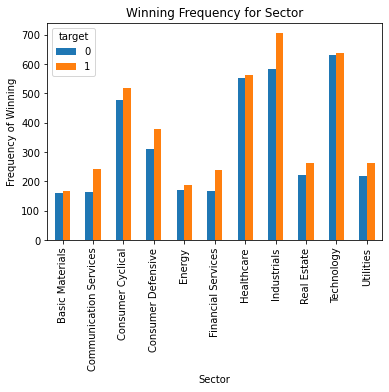

In [18]:
%matplotlib inline
pd.crosstab(dfmdl1.Sector,dfmdl1.target).plot(kind='bar')
plt.title('Winning Frequency for Sector')
plt.xlabel('Sector')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_sector')

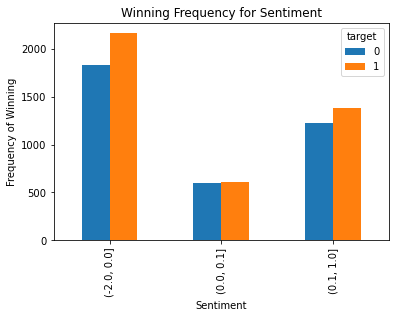

In [19]:
%matplotlib inline
pd.crosstab(dfmdl1.qbin_cs_last5,dfmdl1.target).plot(kind='bar')
plt.title('Winning Frequency for Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_sentiment')

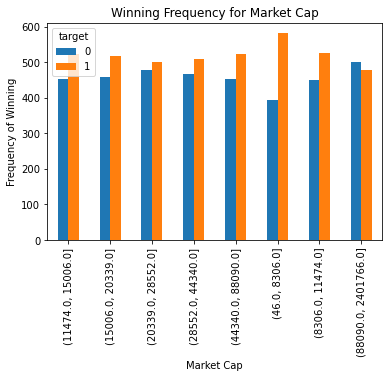

In [20]:
%matplotlib inline
pd.crosstab(dfmdl1.qbin_Market_cap_mm,dfmdl1.target).plot(kind='bar')
plt.title('Winning Frequency for Market Cap')
plt.xlabel('Market Cap')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_marketcap')

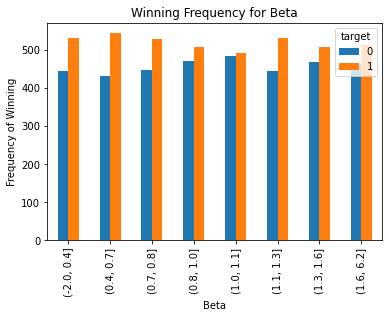

In [21]:
%matplotlib inline
pd.crosstab(dfmdl1.qbin_beta_30avg,dfmdl1.target).plot(kind='bar')
plt.title('Winning Frequency for Beta')
plt.xlabel('Beta')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_beta')

In [22]:
dfmdl1_clean=dfmdl1.drop(columns=['Ticker', 'Fiscal Year', 'Fiscal Period', 'Shares', 'Next_EarningDate','Industry'
                                 ,'qbin_beta_30avg','qbin_cs_last5', 'qbin_Market_cap_mm','EPSsuprise_ind'])

In [23]:
# encode the categorical column
char_var_list=['Sector']
               #, 'qbin_beta_30avg','qbin_cs_last5', 'qbin_Market_cap_mm']
for var in char_var_list:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(dfmdl1_clean[var], prefix=var)
    data1=dfmdl1_clean.join(cat_list)
    dfmdl1_clean=data1

data_vars=dfmdl1_clean.columns.values.tolist()
to_keep=[i for i in data_vars if i not in char_var_list]

dfmdl1_clean=dfmdl1_clean[to_keep]
dfmdl1_clean.columns.values

array(['beta_30avg', 'adjclose', 'Revenue', 'Net_income', 'Cash',
       'Assets', 'CFO', 'CAPX', 'Dividends', 'FCF', 'Revenue_qoq',
       'Revenue_yoy', 'Net_Income_qoq', 'Net_Income_yoy', 'Gross_margin',
       'Gross_margin_qoq', 'Gross_margin_yoy', 'Operating_margin',
       'Operating_margin_qoq', 'Operating_margin_yoy', 'Net_margin',
       'Net_margin_qoq', 'Net_margin_yoy', 'Cash_yoy', 'Assets_yoy',
       'Leverage', 'CFO_qoq', 'FCF_qoq', 'RSI', 'MFI', 'adjclose_SMA_12',
       'adjclose_SMA_30', 'adjclose_EWMA_12', 'adjclose_EWMA_30',
       'adjclose_UpperBand', 'adjclose_LowerBand', 'SMA_12_SMA_30',
       'EWMA_12_EWMA_30', 'UpperBand_LowerBand', '^GSPC',
       '^GSPC_pctchange_5', '^GSPC_pctchange_21', '^GSPC_pctchange_yoy',
       '^RUT', '^RUT_pctchange_5', '^RUT_pctchange_21',
       '^RUT_pctchange_yoy', '^VIX', '^VIX_pctchange_5',
       '^VIX_pctchange_21', '^VIX_pctchange_yoy', 'GC=F',
       'GC=F_pctchange_5', 'GC=F_pctchange_21', 'GC=F_pctchange_yoy',
       '

In [24]:
X=dfmdl1_clean.drop(columns='target')
y=dfmdl1_clean[['target']]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    train_size=0.7)

In [26]:
data_final_vars=X.columns.values.tolist()

logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=1,step=1)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
[62 17  6  4  7  8  9  3  2  5 65 10 37  1 67 82 61 79 75 50 81 69 41 46
 71 51 38 26 21 22 56 58 55 57 60 52 54 53 47 12 48 44 31 13 49 42 28 27
 29 25 16 14 63 64 40 20 30 32 19 43 33 35 24 45 36 34 23 83 18 85 59 15
 39 66 84 11 86 73 76 70 80 72 87 68 78 77 74]


In [28]:
df=pd.DataFrame(list(zip(data_final_vars,rfe.support_,rfe.ranking_)),columns=['variable','Important','Rank']).sort_values(by=['Rank'])
selected_vars=df[df['Rank']<40]
selected_vars.append(['Sector_Basic Materials', 'Sector_Communication Services',
       'Sector_Consumer Cyclical', 'Sector_Consumer Defensive',
       'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare',
       'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology',
       'Sector_Utilities'])
selected_vars

,variable,Important,Rank
13,Net_Income_yoy,True,1
8,Dividends,False,2
7,CAPX,False,3
3,Net_income,False,4
9,FCF,False,5
2,Revenue,False,6
4,Cash,False,7
5,Assets,False,8
6,CFO,False,9
11,Revenue_yoy,False,10


In [29]:
selected_feature=list(selected_vars.variable.values)
X_train_subset=X_train[selected_feature]
X_test_subset=X_test[selected_feature]

### Scaling

In [31]:
data_scaler = StandardScaler()
data_scaler.fit(X_train_subset)

# Scale the training and testing data
X_train_s=data_scaler.transform(X_train_subset)
X_test_s=data_scaler.transform(X_test_subset)

### Not scaling (discard)

In [ ]:
# Not the training and testing data
# absX_train_s=X_train_subset
# X_test_s=X_test_subset

In [32]:
model1 = LogisticRegression(solver='lbfgs', random_state=1)
model1.fit(X_train_s, y_train.values.ravel())

LogisticRegression(random_state=1)

Feature: 0, Score: 0.09540
Feature: 1, Score: 0.03347
Feature: 2, Score: 0.03103
Feature: 3, Score: 0.03625
Feature: 4, Score: 0.02436
Feature: 5, Score: -0.10741
Feature: 6, Score: -0.00634
Feature: 7, Score: 0.06715
Feature: 8, Score: 0.00554
Feature: 9, Score: 0.07514
Feature: 10, Score: -0.02234
Feature: 11, Score: 0.55733
Feature: 12, Score: -0.60409
Feature: 13, Score: -0.17233
Feature: 14, Score: 0.01083
Feature: 15, Score: -0.18981
Feature: 16, Score: 0.18189
Feature: 17, Score: -0.21941
Feature: 18, Score: -0.05980
Feature: 19, Score: 0.32104
Feature: 20, Score: 0.11306
Feature: 21, Score: -0.11877
Feature: 22, Score: 0.05361
Feature: 23, Score: -0.18945
Feature: 24, Score: -0.12652
Feature: 25, Score: 0.03069
Feature: 26, Score: 0.51326
Feature: 27, Score: 0.91353
Feature: 28, Score: 0.03864
Feature: 29, Score: -0.12711
Feature: 30, Score: -0.63182
Feature: 31, Score: -0.04882
Feature: 32, Score: -0.35043
Feature: 33, Score: -0.23161
Feature: 34, Score: 0.13083
Feature: 35, S

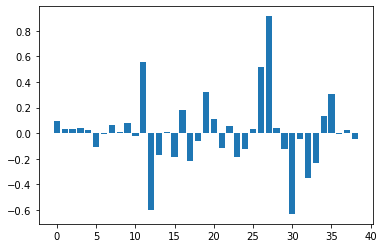

In [33]:
# get importance
importance = model1.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [35]:
selected_vars['coef']=importance.tolist()
selected_vars.sort_values(by=['coef'])

/Users/feiyiyang/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,variable,Important,Rank,coef
42,^GSPC_pctchange_yoy,False,31,-0.631823
43,^RUT,False,13,-0.604085
60,^TNX_pctchange_5,False,33,-0.350430
65,^FVX_pctchange_21,False,34,-0.231611
68,T0,False,18,-0.219409
50,^VIX_pctchange_yoy,False,16,-0.189811
62,^TNX_pctchange_yoy,False,24,-0.189449
51,GC=F,False,14,-0.172327
56,CL=F_pctchange_5,False,30,-0.127111
49,^VIX_pctchange_21,False,25,-0.126515


In [38]:
# Predict outcomes for test data set
y_pred = model1.predict_proba(X_test_s)[:,1]

df_result=pd.DataFrame({"Prediction": y_pred, "Actual": y_test.values.ravel()}).sort_values(by=['Prediction'],ascending=False)
df_result[:10]

,Prediction,Actual
515,0.960873,1
981,0.934760,1
763,0.926232,1
1454,0.911399,1
1984,0.880943,1
855,0.869943,1
1307,0.834584,1
230,0.826409,1
977,0.822158,1
1474,0.791643,1


In [39]:
df_result['Decile'] = pd.qcut(df_result['Prediction'], 10, labels=[i for i in range (10, 0, -1)])
#Calculate the actual churn in each decile
res = pd.crosstab(df_result['Decile'], df_result['Actual'])[1].reset_index().rename(columns = {1: 'Number of Responses'})
lg = df_result['Decile'].value_counts(sort = False).reset_index().rename(columns = {'Decile': 'Number of Cases', 'index': 'Decile'})
lg = pd.merge(lg, res, on = 'Decile').sort_values(by = 'Decile', ascending = False).reset_index(drop = True)
lg

#Calculate the cumulative
lg['Cumulative Responses'] = lg['Number of Responses'].cumsum()
#Calculate the percentage of positive in each decile compared to the total nu
lg['% of Events'] = np.round(((lg['Number of Responses']/lg['Number of Responses'].sum())*100),2)
#Calculate the Gain in each decile
lg['Gain'] = lg['% of Events'].cumsum()
#Calculate the Lift - measures how much better we can expect to do with the predictive model comparing without the model.
lg['Decile'] = lg['Decile'].astype('int')
lg['lift'] = np.round((lg['Gain']/(lg['Decile']*10)),2)
lg

,Decile,Number of Cases,Number of Responses,Cumulative Responses,% of Events,Gain,lift
0,1,235,160,160,12.72,12.72,1.27
1,2,234,146,306,11.61,24.33,1.22
2,3,234,135,441,10.73,35.06,1.17
3,4,235,136,577,10.81,45.87,1.15
4,5,234,132,709,10.49,56.36,1.13
5,6,234,132,841,10.49,66.85,1.11
6,7,235,115,956,9.14,75.99,1.09
7,8,234,93,1049,7.39,83.38,1.04
8,9,234,107,1156,8.51,91.89,1.02
9,10,235,102,1258,8.11,100.00,1.00


The lift could be interpreted as the gain ratio percentage to the random percentage at a given decile level. In a layman term, in decile 2, we have 1.22 means that when selecting 20% of the data based on the model, we could find the target (actual positive return) 1.22 times more than the randomly selected 20% of the data without a model.